# CITS4403 Project draft code

### Config


In [81]:
import matplotlib.pyplot as plt
from scipy.signal import correlate2d
import numpy as np
from time import sleep
from IPython.display import clear_output
import random
from typing import Self

## Parameters
ROOM_TEMPERATURE_CELSIUS = 25
HEAT_FIRE_STARTS_CELSIUS = 100

# Fire parameters
FIRE_EMISSION_CELSIUS = 20
FIRE_MAX_HEAT_CELSIUS = 1000
FIRE_EMISSION_KERNEL = np.array([[0, 0.4, 0], [0.4, 0.4, 0.4], [0, 0.4, 0]])

# Smoke parameters
SMOKE_EMISSION_KERNEL = np.array([[0, 0.8, 0], [0.8, 0.8, 0.8], [0, 0.8, 0]])
SMOKE_DISPERSION = 0.1

# Heat parameters
HEAT_DISPERSION = 0.04

# Display parameters
MAX_HEAT_DISPLAY_CELSIUS = 100
MIN_HEAT_DISPLAY_CELSIUS = 25
MAX_HEAT_TRANSPARENCY = 0.5

# Agent parameters
NUM_AGENTS = 8
INHALATION_MODIFIER = 0.5

In [2]:
from typing import Generator

from PIL import Image

map = np.array(Image.open('data/1_gt_14.png'))

def border_elements(map: np.ndarray) -> Generator[int, None, None]:
    if map.ndim != 2:
        raise ValueError("Input array must be 2D.")

    rows, cols = map.shape
    
    # Top row
    for col in range(cols):
        yield (col, 0)
    
    # Right column
    for row in range(1, rows - 1):
        yield (cols - 1, row)
    
    # Bottom row
    for col in range(cols - 1, -1, -1):
        yield (col, rows - 1)
    
    # Left column
    for row in range(rows - 2, 0, -1):
        yield (0, row)

map_exits = [(np.int64(x), np.int64(y)) for x, y in border_elements(map) if map[y][x] == 0]

In [3]:
def get_random_empty_position(map: np.ndarray) -> tuple:
    zero_positions = np.argwhere(map == 0)
    
    random_index = random.choice(range(len(zero_positions)))
    return tuple(zero_positions[random_index])

In [4]:
class Cell:
    def __init__(self, isBurnable):
        self.heatCelsius = ROOM_TEMPERATURE_CELSIUS

        self.smokeContent = 0
        self.isBurnable = isBurnable

        self.isOnFire = False

def hollow_dispersion_kernel(dispersion: float) -> np.ndarray:
    return np.array([[0, dispersion, 0], [dispersion, 0, dispersion], [0, dispersion, 0]])

def dispersion_kernel(dispersion: float) -> np.ndarray:
    return np.array([[0, dispersion, 0], [dispersion, 1 - 4 * dispersion, dispersion], [0, dispersion, 0]])


In [5]:
from heapq import heappop, heappush

# A* - modified to compute costs of all cells from nearest exit
def a_star_reverse(map, exits: list[tuple[int, int]]) -> dict[tuple[int, int], int]:
    pqueue = [] # Priority queue of (cost, (x, y)) tuples
    cost_map = {} # Maps (x, y) to lowest cost to an exit

    for exit in exits:
        heappush(pqueue, (0, exit))
        cost_map[exit] = 0

    while pqueue:
        # Node with next lowest cost
        current_cost, current = heappop(pqueue)

        # Check all possible moves (up, down, left, right)
        for dx, dy in [(0, 1), (0, -1), (1, 0), (-1, 0)]:
            neighbor = (current[0] + dx, current[1] + dy)

            if not (0 <= neighbor[0] < len(map[0]) and 0 <= neighbor[1] < len(map)):
                continue
            if map[neighbor[1]][neighbor[0]] != 0: # walkable space
                continue

            current_neighbour_cost = current_cost + 1 # Cost is 1 for each step for now

            # If this is the best path to neighbor, record it
            if neighbor not in cost_map or current_neighbour_cost < cost_map[neighbor]:
                cost_map[neighbor] = current_neighbour_cost
                heappush(pqueue, (current_neighbour_cost, neighbor))

    return cost_map

In [6]:
class Person:
    def __init__(self, map):
        self.map = map
        self.moving = False
        self.smokeInhalationLevel = 0

        self.y, self.x = get_random_empty_position(self.map)

    def move_towards_exit(self, cost_map: dict[tuple[int, int], int]):
        if self.moving:
            return 0

        # If the person is already at an exit, they are safe
        if (self.x, self.y) in map_exits:
            self.moving = False
            return 1

        current_cost = cost_map.get((self.x, self.y), float('inf'))
        best_move = (self.x, self.y)
        for dx, dy in [(0, 1), (0, -1), (1, 0), (-1, 0)]:
            neighbor = (self.x + dx, self.y + dy)

            if not (0 <= neighbor[0] < len(map[0]) and 0 <= neighbor[1] < len(map)):
                continue
            if map[neighbor[1]][neighbor[0]] != 0: # walkable spaces
                continue

            if cost_map[neighbor] <= current_cost:
                best_move = neighbor
                current_cost = cost_map[neighbor]

        # Move the person to the best move
        self.x, self.y = best_move

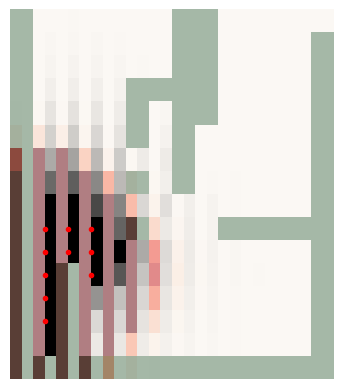

Number of people safe: 8


In [95]:
class Simulation():
    def __init__(self: Self, map, num_people: int, initialCell: tuple[int, int]) -> None:
        self.environment = np.array([[Cell(not isWall) for isWall in row] for row in map])

        initialCellY, initialCellX = initialCell

        self.environment[initialCellY][initialCellX].heatCelsius = 150
        self.environment[initialCellY][initialCellX].isOnFire = True

        self.people = [Person(map) for _ in range(num_people)]
        self.cost_map = a_star_reverse(map, map_exits)  # Pre compute A* for each exit

        # Metrics
        self.num_safe = 0
        self.num_dead = 0

    def step(self):
        # Move all people
        for person in self.people:
            cell = self.environment[person.y][person.x]
            if cell.isOnFire:
                self.num_dead += 1
                person.moving = False
                self.people.remove(person)
                continue
            
            res = person.move_towards_exit(self.cost_map)
            if res == 1:
                self.num_safe += 1
                self.people.remove(person)

        # Calculate heat dispersion
        heatMap = np.array([[cell.heatCelsius for cell in row] for row in self.environment])
        heatDispersion = correlate2d(heatMap, dispersion_kernel(HEAT_DISPERSION), mode='same', boundary='fill', fillvalue=ROOM_TEMPERATURE_CELSIUS)

        # Calculate heat emissions from fire using convolution
        fires = np.array([[cell.isOnFire for cell in row] for row in self.environment])
        heatEmissions = correlate2d(fires, FIRE_EMISSION_KERNEL, mode='same', boundary='fill', fillvalue=0)

        # Add heat emissions to environment
        for i in range(len(self.environment)):
            for j in range(len(self.environment[i])):
                cell = self.environment[i][j]
                cell.heatCelsius = heatDispersion[i][j] + heatEmissions[i][j] * FIRE_EMISSION_CELSIUS
                cell.heatCelsius = min(cell.heatCelsius, FIRE_MAX_HEAT_CELSIUS)

                if cell.heatCelsius >= HEAT_FIRE_STARTS_CELSIUS and cell.isBurnable:
                    cell.isOnFire = True

        self.step_calculate_smoke(fires)

        # Calculate smoke inhalation
        for person in self.people:
            person.smokeInhalationLevel += min(self.environment[person.y][person.x].smokeContent * INHALATION_MODIFIER, 1)
            if person.smokeInhalationLevel == 1:
                self.num_dead += 1
                self.people.remove(person)

    def step_calculate_smoke(self, fires):
        # Calculate smoke dispersion:

        # 1. Calculate the neighbours of each cell, encoded as a bitset
        emptySpaceMap = np.array([[cell.isBurnable for cell in row] for row in self.environment])
        neighboursMap = correlate2d(emptySpaceMap, np.array([[0, 2, 0], [4, 0, 1], [0, 8, 0]]), mode='same', boundary='fill', fillvalue=0)

        # 2. Calculate dispersion
        # Smoke modifications are a map of additions to the smoke content of each cell
        smokeModifications = np.zeros((len(self.environment), len(self.environment[0])))
        for y in range(len(self.environment)):
            for x in range(len(self.environment[y])):
                cell = self.environment[y][x]

                # If no smoke or neighbours are present, skip
                if (cell.smokeContent == 0 or neighboursMap[y][x] == 0):
                    continue

                # Get number of neighbours
                neighbours = neighboursMap[y][x]
                numNeighbours = bin(neighbours).count('1')

                # Remove smoke from cell
                newSmokeValue = cell.smokeContent * SMOKE_DISPERSION
                smokeModificationAdjustment = newSmokeValue - cell.smokeContent # Will be negative- smoke is dispersing from this tile
                smokeModifications[y][x] += smokeModificationAdjustment

                # Calculate how much smoke is going to each cell- will be positive
                smokeSpread = -smokeModificationAdjustment / numNeighbours

                # Add smoke to neighbours
                for neighbour in [[1, 0], [0, -1], [-1, 0], [0, 1]]:
                    # There should never be a risk of going out of bounds with the convolution done before
                    neighbourX = x + neighbour[0]
                    neighbourY = y + neighbour[1]

                    if neighbours & 1:
                        smokeModifications[neighbourY][neighbourX] += smokeSpread
                    neighbours >>= 1

        # Calculate smoke emission from fire
        newSmoke = correlate2d(fires, SMOKE_EMISSION_KERNEL, mode='same', boundary='fill', fillvalue=0)

        # Multiply smoke emissions by empty space map to prevent smoke from spreading to wall cells
        # If a cell is not burnable (0) then the smoke emission to that cell is 0
        # If a cell is burnable (1) then the smoke emission to that cell is the original smoke emission
        newSmoke *= emptySpaceMap

        # Add smoke emissions to environment, with a maximum value out at 100%
        for y in range(len(self.environment)):
            for x in range(len(self.environment[y])):
                cell = self.environment[y][x]
                cell.smokeContent = min(cell.smokeContent + smokeModifications[y][x] + newSmoke[y][x], 1)

    def draw(self):
        height, width = map.shape

        plt.axis('off')
        plt.xticks([])
        plt.yticks([])

        wallsMap = np.where(map == 1, 1, 0)
        options={
            "cmap": 'Greens',
            "alpha": 0.7,
            "vmin": 0, "vmax": 1,
            "interpolation": 'none',
            "origin": 'upper',
            "extent": [0, width, 0, height]
        }

        plt.imshow(wallsMap, **options)

        # Draw heat on the environment
        heatMap = np.array([[min(cell.heatCelsius - MIN_HEAT_DISPLAY_CELSIUS, MAX_HEAT_DISPLAY_CELSIUS) / MAX_HEAT_TRANSPARENCY for cell in row] for row in self.environment])
        leftAlignedHeatMap = np.zeros((height, width * 2), dtype=heatMap.dtype)
        leftAlignedHeatMap[:, ::2] = heatMap
        options={
            "cmap": 'Reds',
            "alpha": 0.5,
            "vmin": 0, "vmax": 1,
            "interpolation": 'none',
            "origin": 'upper',
            "extent": [0, width, 0, height]
        }

        plt.imshow(leftAlignedHeatMap, **options)

        # Draw smoke on the environment
        smokeMap = np.array([[cell.smokeContent for cell in row] for row in self.environment])
        options={
            "cmap": 'gray',
            "alpha": 1,
            "vmin": 0, "vmax": 1,
            "interpolation": 'none',
            "origin": 'upper',
            "extent": [0, width, 0, height]
        }

        rightAlignedSmokeMap = np.zeros((height, width * 2, 4), dtype=smokeMap.dtype)
        rightAlignedSmokeMap[:, 1::2, 3] = smokeMap

        plt.imshow(rightAlignedSmokeMap, **options)

        # Draw fire
        fireXs = []
        fireYs = []
        for y in range(height):
            for x in range(width):
                cell = self.environment[y][x]
                if cell.isOnFire:
                    fireXs.append(x + 0.5)
                    fireYs.append(height - y - 0.5)
        plt.plot(fireXs, fireYs, '.', color='red')

        # Draw people as green dots
        for person in self.people:
            plt.plot(person.x + 0.5, height - person.y - 0.5, '.', color='green')

        plt.show()

    def simulate(self, frames, interval=None) -> int:
        """Simulate the automaton.

        frames: number of frames to draw
        interval: time between frames in seconds
        iters: number of steps between frames
        """

        try:
            for _ in range(frames-1):
                if interval:
                    sleep(interval)
                self.step()
        except KeyboardInterrupt:
            pass

        return self.num_safe

    def animate(self, frames, interval=None):
        """Animate the automaton.

        frames: number of frames to draw
        interval: time between frames in seconds
        iters: number of steps between frames
        """

        try:
            for _ in range(frames-1):
                self.draw()
                if interval:
                    sleep(interval)
                self.step()
                clear_output(wait=True)
            self.draw()
        except KeyboardInterrupt:
            pass

        print(f"Number of people safe: {self.num_safe}")

sim = Simulation(map, NUM_AGENTS, get_random_empty_position(map))

sim.animate(30, 0.1)

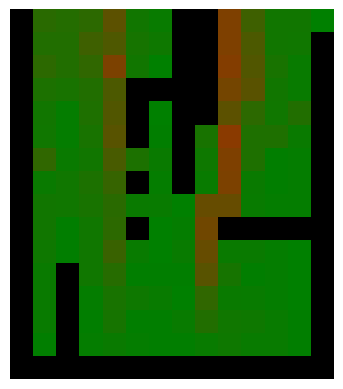

In [98]:
# For every empty cell in the map, run the simulation and calculate the number of people saved depending on their starting tile

from matplotlib.colors import LinearSegmentedColormap


def run_simulation(map, num_agents, num_runs):
    output = np.zeros(map.shape)

    for cell in np.ndindex(map.shape):
        if map[cell] != 0:
            output[cell] = -1
            continue

        num_safe = 0
        for _ in range(num_runs):
            sim = Simulation(map, num_agents, tuple(cell))
            num_safe += sim.simulate(60)
        output[cell] = num_safe / num_runs

    # Draw the output
    plt.axis('off')
    plt.xticks([])
    plt.yticks([])
    plt.imshow(output, cmap=LinearSegmentedColormap.from_list("hazardous_fire_starts", ["black", "red", "green"]))

run_simulation(map, NUM_AGENTS, 20)